# Deep hedging

We build a framework to hedge options.

In [ ]:
import numpy as np
import time
import matplotlib.pyplot as plt

In [9]:
class GBMOptionEnv:
    """
    Environment with:
    - GMB stock price
    - one call option
    """
    
    def __init__(self, tau=1/4, K=100., mu=0.0, sig=0.2, trans_cost=0.0):
        """
        Initialize the environment.
        """
        ## price dynamics and option
        self.tau = tau    ## time to maturity
        self.K = K        ## strike price
        self.sig = sig    ## volatility parameter
        self.mu = mu      ## real-world drift
        self.d = 0.0      ## dividend yield
        self.r = 0.0      ## risk-free rate
        self.S0 = 100.    ## initial underlying price
        self.dt = 1./52 ## time increment
        self.n = np.int(self.tau / self.dt) ## total number of steps
        self.ttms = np.linspace(tau, 0, self.n+1)
        ## frictions
        self.trans_cost = trans_cost
        
    def _payoff(self, S):
        """
        Option payoff function
        """
        return max(0., S-self.K)
        
    def reset(self):
        """
        Reset the episode
        Generate the entire price time series (as we assume not price impact)
        """
        dW = np.random.randn(self.n)*np.sqrt(self.dt)          ## innovations
        lr = (self.mu - 0.5*self.sig**2)*self.dt + self.sig*dW ## log-returns
        self.prices = self.S0*np.exp(np.cumsum(lr)) ## stock prices
        self.prices = np.insert(self.prices, 0, self.S0)
        self.istep = 0                              ## current step
        self.pi = 0.                                ## current number of shares in the risky-asset
        self.Si = self.S0                           ## current price
        self.ttm = (self.n - self.istep)*self.dt ## time to maturity
        return np.array([self.ttm, self.Si, self.pi], dtype=float)
        
    def step(self, pi):
        """
        Invest pi in the stock, move to the next time step and compute the P&L, proportional transaction costs
        """
        ## compute transaction costs
        Si = self.Si
        ##-----
        ## TODO
        ##-----
        costs = np.abs(self.pi - pi) * Si * self.trans_cost
        ## get new step and new price
        self.istep += 1
        Sii = self.prices[self.istep]
        ## compute P&L
        ##-----
        ## TODO
        ##-----
        pnl = (Sii * Si) * pi
        if self.istep == self.n:
            done = True
            pnl += - self._payoff(Sii)
        else:
            done = False
        ## update current state
        self.pi = pi
        self.Si = Sii
        self.ttm = (self.n - self.istep)*self.dt
        state_next = np.array([self.ttm, self.Si, self.pi], dtype=float)
        ## message
        info = ""
        ## compute reward
        reward = pnl - costs
        return state_next, reward, done, info

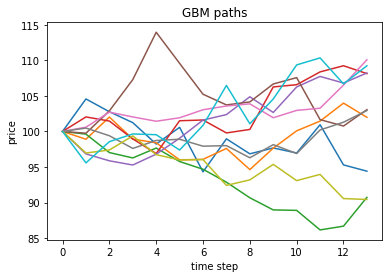

In [10]:
## simulate some price trajectories
env = GBMOptionEnv()
plt.figure()
np.random.seed(1)
for i in range(10):
    env.reset()
    plt.plot(env.prices)
plt.title("GBM paths")
plt.xlabel("time step")
plt.ylabel("price")
plt.show()

## Black-Scholes-Merton formula

In [11]:
import scipy.stats as stats

def BSM_d1(S, tau, r, d, sigma, K):
    return (np.log(S/K) + (r-d+sigma**2/2)*tau) / (sigma*np.sqrt(tau))

def BSM_price(S, tau, r, d, sigma, K):
    Phi = stats.norm(loc=0, scale=1).cdf
    d1 = BSM_d1(S, tau, r, d, sigma, K)
    d2 = d1 - sigma*np.sqrt(tau)
    return S*np.exp(-d*tau)*Phi(d1) - K*np.exp(-r*tau)*Phi(d2)

def BSM_delta(S, tau, r, d, sigma, K):
    d1 = BSM_d1(S, tau, r, d, sigma, K)
    Phi = stats.norm(loc=0, scale=1).cdf
    return np.exp(-d*tau)*Phi(d1)

## Delta agent

The agent uses the BSM Delta to hedge the call option.

In [12]:
class DeltaAgent:
    
    def __init__(self, env):
        """
        Initialize the agent
        """
        self.env = env
    
    def act(self, state):
        """
        Hedge the option using the Black-Scholes Delta
        """
        ttm, S, _ = state
        delta = BSM_delta(S, ttm, r=self.env.r, d=self.env.d, sigma=self.env.sig, K=self.env.K)
        return delta
    
    def train(self):
        """
        No training!
        """
        pass
    
    def test(self, number_of_tests):
        rewards = []
        for _ in range(number_of_tests):
            s = self.env.reset()
            total_reward = 0.
            for t in range(self.env.n):
                a = self.act(s)
                s, reward, done, info = self.env.step(a)
                total_reward += reward
            rewards.append(total_reward)
        return rewards

In [13]:
def plot_rewards(rewards):
    plt.figure()
    plt.hist(rewards)
    plt.title("Option replication P&Ls (without initial premium)")
    plt.xlabel("P&L")
    plt.xlabel("# of observations")
    plt.axvline(x=-price, color="red")
    plt.show()

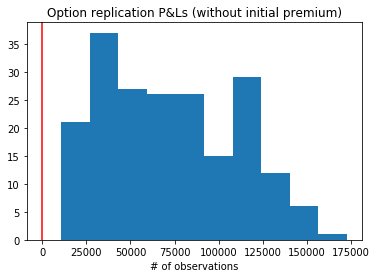

In [14]:
env = GBMOptionEnv(trans_cost = 0.0)
delta_agent = DeltaAgent(env)
n_test = 200
rewards_delta = delta_agent.test(n_test)

price = BSM_price(env.S0, env.tau, env.r, env.d, env.sig, env.K)

plot_rewards(rewards_delta)

## RNN - CVaR

The agent tries to maximize its $\alpha$-CVaR while following a RNN policy $\pi_\theta$.

In [15]:
import tensorflow as tf
import progressbar as pgb

/home/alexander/.local/lib/python3.6/site-packages/tensorflow/python/framework/dtypes.py:516: FutureWarning: Passing (type, 1) or '1type' as a synonym of type is deprecated; in a future version of numpy, it will be understood as (type, (1,)) / '(1,)type'.
  _np_qint8 = np.dtype([("qint8", np.int8, 1)])
/home/alexander/.local/lib/python3.6/site-packages/tensorflow/python/framework/dtypes.py:517: FutureWarning: Passing (type, 1) or '1type' as a synonym of type is deprecated; in a future version of numpy, it will be understood as (type, (1,)) / '(1,)type'.
  _np_quint8 = np.dtype([("quint8", np.uint8, 1)])
/home/alexander/.local/lib/python3.6/site-packages/tensorflow/python/framework/dtypes.py:518: FutureWarning: Passing (type, 1) or '1type' as a synonym of type is deprecated; in a future version of numpy, it will be understood as (type, (1,)) / '(1,)type'.
  _np_qint16 = np.dtype([("qint16", np.int16, 1)])
/home/alexander/.local/lib/python3.6/site-packages/tensorflow/python/framework/dty

In [17]:
class RNNCVaRAgent:
    
    def __init__(self, env, batch_size, alpha=0.5, gamma=1.0, lr=0.01, 
                 nodes=[50, 50, 1], 
                 activations=["sigmoid", "sigmoid", "sigmoid"]):
        """
        Initialize the agent
        """
        self.env = env
        self.gamma = gamma
        self.alpha = alpha
        self.nodes = nodes
        self.activations = activations
        self.batch_size = batch_size
        self.lr = lr
        
        ## Prepare TF model
        tf.reset_default_graph()
        self.sess = tf.Session()
        self.model = self._build_model()
        self.sess.run(tf.initialize_all_variables())
        
    def _build_model(self):
        """
        RNN model that aim to maximize the alpha-CVaR of the portfolio P&L
        """
        ## input
        self.states = tf.placeholder(tf.float32, [self.env.n+1, self.batch_size, 2]) ## only two features here!!!
        ## price at maturity
        Smat = self.states[-1,:,0]
        ## price increments
        dS = self.states[1:, :, 0] - self.states[0:-1, :, 0]
        
        ## prepare states for RNN, remove the last time
        ## unstack as input to "static_rnn" should be a list of [batch_size, features_size]
        states_t = tf.unstack(self.states[:-1, :,:], axis=0) 
        
        ## RNN model
        ##-----
        ## TODO: in tensorflow
        ##-----
        cells = [tf.contrib.rnn.BasicRNNCell(self.nodes[i], activation=self.activations[i]) for i in range(len(self.nodes))]
        rnn = tf.contrib.rnn.MultiRNNCell(cells)
        self.strategy, state = tf.nn.static_rnn(rnn, 
                                                states_t, 
                                                initial_state=rnn.zero_state(self.batch_size, tf.float32), 
                                                dtype=tf.float32)
        self.strategy = tf.reshape(self.strategy, (self.env.n, self.batch_size))
        
        ## option payoff at maturity
        self.option = tf.maximum(Smat - self.env.K, 0)
        
        ## daily and final P&L
        self.pnl_by_step = dS*self.strategy
        self.pnl = tf.reduce_sum(self.pnl_by_step, axis=0) - self.option
        
        ## compute the CVaR for the confidence level alpha
        ## 1. get the largest losses
        neg_losses, idx = tf.nn.top_k(-self.pnl, int((1-self.alpha)*self.batch_size))
        ## 2. compute their mean
        CVaR = tf.reduce_mean(neg_losses)
        
        ## train op
        self.train_op = tf.train.AdamOptimizer(learning_rate=self.lr).minimize(CVaR)
    
    ## XXX: not applicable here as all hedges are generated by the same model
    #def act(self, state):
    #    return self.estimator_policy.predict(state, self.sess)
    
    def _generate_one_batch(self):
        states = []
        for i in range(self.batch_size):
            self.env.reset()
            features = np.vstack([self.env.prices, self.env.ttms]).T.reshape(-1,1,2)
            states.append(features)
        states = np.concatenate(states, axis=1)
        return(states)
    
    def _run_on_batches(self, number_of_episodes, train=True):
        num_batches = int(np.ceil(number_of_episodes/self.batch_size))
        rewards = []
        ## visual for the current episode
        bar = pgb.ProgressBar(maxval=num_batches, 
                              widgets=[pgb.Bar('=', '[', ']'), 
                                       ' ', pgb.Percentage()])
        bar.start()
        for e in range(num_batches):
            ## pre-processing
            states = self._generate_one_batch()
            
            if train:
                _, pnl = self.sess.run([self.train_op, self.pnl], {self.states: states})
            else:
                 pnl = self.sess.run(self.pnl, {self.states: states})
            rewards.append(pnl)
            
            ## update bar
            bar.update(e + 1)
            
        rewards = np.array(rewards).reshape(-1)   
        return rewards
        
    def train(self, number_of_episodes):
        return self._run_on_batches(number_of_episodes, True)
    
    def test(self, number_of_episodes):
        return self._run_on_batches(number_of_episodes, False)
    
    def get_strategy_batch_sample(self):
        states = self._generate_one_batch()
        strat, pnl, pnl_by_step= self.sess.run([self.strategy, self.pnl, self.pnl_by_step], {self.states: states})
        return strat, pnl, pnl_by_step, states
    
    def get_deltas_sample(self):
        prices = np.linspace(75, 125, self.batch_size)
        ttms = self.env.ttms
        states = []
        for i in range(self.batch_size):
            features = np.vstack([np.ones(self.env.n+1)*prices[i], ttms]).T.reshape(-1,1,2)
            states.append(features)
        states = np.concatenate(states, axis=1)
        strat, pnl = self.sess.run([self.strategy, self.pnl], {self.states: states})
        return strat, pnl, prices

The TensorFlow contrib module will not be included in TensorFlow 2.0.
For more information, please see:
  * https://github.com/tensorflow/community/blob/master/rfcs/20180907-contrib-sunset.md
  * https://github.com/tensorflow/addons
  * https://github.com/tensorflow/io (for I/O related ops)
If you depend on functionality not listed there, please file an issue.

Instructions for updating:
This class is equivalent as tf.keras.layers.SimpleRNNCell, and will be replaced by that in Tensorflow 2.0.
Instructions for updating:
This class is equivalent as tf.keras.layers.StackedRNNCells, and will be replaced by that in Tensorflow 2.0.
Instructions for updating:
Please use `keras.layers.RNN(cell, unroll=True)`, which is equivalent to this API
Instructions for updating:
Call initializer instance with the dtype argument instead of passing it to the constructor
Instructions for updating:
Call initializer instance with the dtype argument instead of passing it to the constructor


Instructions for updating:
Use `tf.global_variables_initializer` instead.


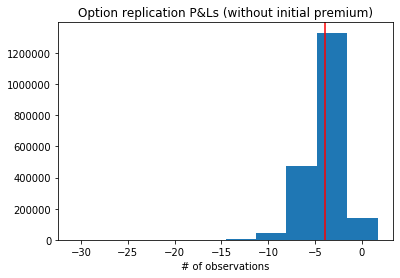

In [18]:
env = GBMOptionEnv()
agent = RNNCVaRAgent(env=env, batch_size=int(1e4))
rewards_rnn = agent.train(number_of_episodes=int(2e6))
plot_rewards(rewards_rnn)

In [ ]:
## Need to train longer sometimes
#rewards_rnn = agent.train(number_of_episodes=int(1e6))
#plot_rewards(rewards_rnn)[======                                                                  ]   9%


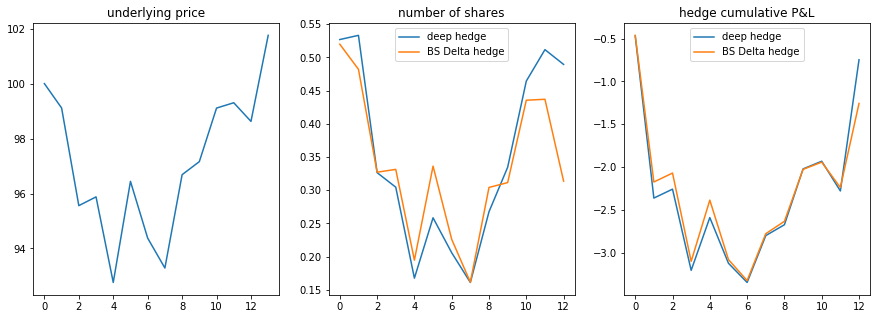

In [19]:
strat, pnl, pnl_by_step, states = agent.get_strategy_batch_sample()

plt.figure(figsize=(15,5))
plt.subplot(1,3,1)
plt.plot(states[:,0,0]) ## prices
plt.title("underlying price")
plt.subplot(1,3,2)
strat_bs = [BSM_delta(states[i,0,0], states[i,0,1], env.r, env.d, env.sig, env.K) for i in range(env.n)]
plt.plot(strat[:,0])    ## delta
plt.plot(strat_bs)    ## BSM delta
plt.title("number of shares")
plt.legend(["deep hedge","BS Delta hedge"])
plt.subplot(1,3,3)
plt.plot(np.cumsum(pnl_by_step[:,0]))
pnl_by_step_bsm = (states[1:,0,0] - states[:-1,0,0])*strat_bs
plt.plot(np.cumsum(pnl_by_step_bsm))
plt.title("hedge cumulative P&L")
plt.legend(["deep hedge","BS Delta hedge"])
plt.show()

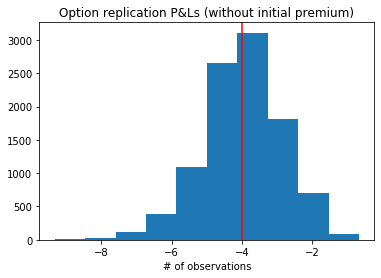

In [20]:
rewards_rnn_test = agent.test(1000)
plot_rewards(rewards_rnn_test)

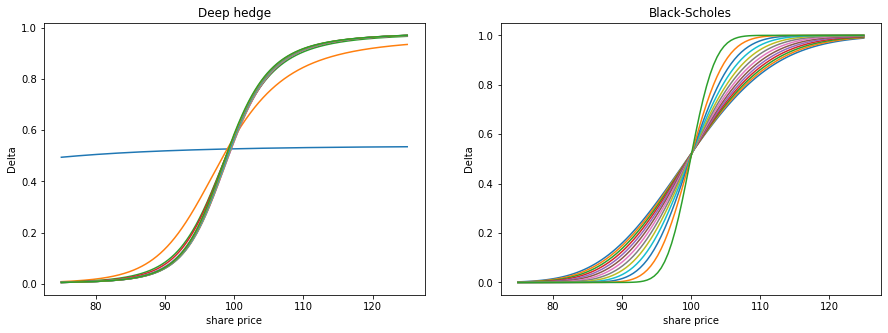

In [21]:
strat, pnl, prices = agent.get_deltas_sample()

plt.figure(figsize=(15,5))
plt.subplot(1,2,1)
plt.title("Deep hedge")
plt.xlabel("share price")
plt.ylabel("Delta")
for i in range(agent.env.n):
    plt.plot(prices, strat[i,:])
plt.subplot(1,2,2)
plt.title("Black-Scholes")
plt.xlabel("share price")
plt.ylabel("Delta")
prices = np.linspace(75,125,100)
for i in range(agent.env.n):
    delta = [BSM_delta(p, env.ttms[i], env.r, env.d, env.sig, env.K) for p in prices]
    plt.plot(prices, delta)
plt.show()